# Entrenamiento de los modelos
Aquí vamos a entrenar los distintos modelos que consideremos para predecir la cantidad de cada tipo de cítrico que importará cada país de la UE.

## Carga de los datos y selección del producto o el partner

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [4]:
df = pd.read_csv('./Countries_citricos_completos/Germany.csv')

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df['Mes'] = df['Date'].dt.month
# Limones
df = df.loc[df['Product'] == 'Fresh or dried lemons', :]

df = df.groupby(['Date'], as_index=False).agg({
    'kg': 'sum', 
    **{col: 'first' for col in df.columns if col not in ['Date', 'kg', 'Partner', 'Member State']}
})
df = df.sort_values('Date', ascending=True).reset_index(drop=True)
df

,Date,kg,Product,Euro Value,Unit Value,Año,Precipitación,Temperatura,Fem. Niños (5-14 años),Fem. Adolescentes (15-19 años),...,Fem. Adultos mayores (55-74 años),Fem. Ancianos (75+ años),Masc. Niños (5-14 años),Masc. Adolescentes (15-19 años),Masc. Adultos jóvenes (20-34 años),Masc. Adultos medios (35-54 años),Masc. Adultos mayores (55-74 años),Masc. Ancianos (75+ años),PIB per capita,Mes
0,2014-10-01,19790.0,Fresh or dried lemons,21491.94,1.086000,2014,65.853,12.643,3520903.0,1964687.0,...,10019272.0,2187585.0,3712037.0,2075810.0,7490366.0,8492130.0,9353285.0,1710150.0,128.0,10
1,2014-10-06,56574.0,Fresh or dried lemons,170.00,1.700000,2014,65.853,12.643,3520903.0,1964687.0,...,10019272.0,2187585.0,3712037.0,2075810.0,7490366.0,8492130.0,9353285.0,1710150.0,128.0,10
2,2014-10-13,96419.0,Fresh or dried lemons,255.00,1.700000,2014,65.853,12.643,3520903.0,1964687.0,...,10019272.0,2187585.0,3712037.0,2075810.0,7490366.0,8492130.0,9353285.0,1710150.0,128.0,10
3,2014-10-20,48970.0,Fresh or dried lemons,1585.50,0.556316,2014,65.853,12.643,3520903.0,1964687.0,...,10019272.0,2187585.0,3712037.0,2075810.0,7490366.0,8492130.0,9353285.0,1710150.0,128.0,10
4,2014-10-27,83059.0,Fresh or dried lemons,142.50,1.900000,2014,65.853,12.643,3520903.0,1964687.0,...,10019272.0,2187585.0,3712037.0,2075810.0,7490366.0,8492130.0,9353285.0,1710150.0,128.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,2024-10-07,6.5,Fresh or dried lemons,10.00,10.000000,2024,62.614,11.795,4011538.0,1944184.0,...,11824668.0,1719768.0,4237452.0,2093028.0,7918874.0,8433090.0,11117213.0,1389490.0,114.0,10
506,2024-10-14,4074.0,Fresh or dried lemons,81.00,40.500000,2024,62.614,11.795,4011538.0,1944184.0,...,11824668.0,1719768.0,4237452.0,2093028.0,7918874.0,8433090.0,11117213.0,1389490.0,114.0,10
507,2024-10-21,4882.1,Fresh or dried lemons,2772.00,2.613122,2024,62.614,11.795,4011538.0,1944184.0,...,11824668.0,1719768.0,4237452.0,2093028.0,7918874.0,8433090.0,11117213.0,1389490.0,114.0,10
508,2024-10-28,201.6,Fresh or dried lemons,80.00,0.400000,2024,62.614,11.795,4011538.0,1944184.0,...,11824668.0,1719768.0,4237452.0,2093028.0,7918874.0,8433090.0,11117213.0,1389490.0,114.0,10


In [6]:
f = df.drop(['Product','Date', 'Euro Value', 'Unit Value', 'Mes', 'Año'], axis=1)
correlaciones = f.corr()
print(correlaciones['kg'].sort_values(ascending=False))

kg                                    1.000000
Temperatura                           0.554414
Precipitación                         0.145089
Masc. Adultos medios (35-54 años)     0.090887
Masc. Adultos jóvenes (20-34 años)    0.038288
PIB per capita                        0.033515
Masc. Ancianos (75+ años)             0.032151
Fem. Ancianos (75+ años)              0.024817
Masc. Adultos mayores (55-74 años)   -0.013457
Fem. Adultos mayores (55-74 años)    -0.024631
Fem. Adultos jóvenes (20-34 años)    -0.040810
Fem. Adultos medios (35-54 años)     -0.044453
Masc. Niños (5-14 años)              -0.070934
Fem. Niños (5-14 años)               -0.072992
Masc. Adolescentes (15-19 años)      -0.075393
Fem. Adolescentes (15-19 años)       -0.086043
Name: kg, dtype: float64


## Predicciones de temperatura y precipitación
Aquí generamos los datos de temperatura y precipitación a un año vista, asumiendo que el clima no va a cambiar mucho, añadiendo algo de ruido sobre los valores de años anteriores. 

In [16]:
# Seleccionamos las variables climáticas
df_clima = df.copy()
df_clima = df_clima[['Mes','Año','Temperatura','Precipitación']]

# Creamos un dataframe para las previsiones a 1 año vista
df_prevision_clima = pd.DataFrame({'Mes':[10,11,12,1,2,3,4,5,6,7,8,9,10],'Año':[2024,2024,2024,2025,2025,2025,2025,2025,2025,2025,2025,2025,2025],
                             'Temperatura':13*np.nan, 'Precipitación':13*np.nan})

# Calculamos las medias de cada mes durante los años disponibles
medias_temperatura = df_clima.groupby('Mes')['Temperatura'].mean()
medias_precipitacion = df_clima.groupby('Mes')['Precipitación'].mean()

# Asignamos las medias a las previsiones
df_prevision_clima['Temperatura'] = df_prevision_clima['Mes'].map(medias_temperatura)
df_prevision_clima['Precipitación'] = df_prevision_clima['Mes'].map(medias_precipitacion)
display(df_prevision_clima)


,Mes,Año,Temperatura,Precipitación
0,10,2024,11.842093,64.709667
1,11,2024,6.779093,59.528674
2,12,2024,3.526628,67.997442
3,1,2025,2.074244,68.816311
4,2,2025,2.966366,56.060707
5,3,2025,5.795676,49.900000
6,4,2025,9.193812,47.752156
7,5,2025,13.487390,63.426537
8,6,2025,18.016262,74.698762
9,7,2025,19.342267,77.150911


In [71]:
df_prevision_clima['ds'] = pd.to_datetime(df_prevision_clima['Año'].astype(str) + '-' + df_prevision_clima['Mes'].astype(str) + '-01')
df_prevision_clima = df_prevision_clima.set_index('ds')

# Propagar los valores mensuales a frecuencia semanal
datos_climaticos_semanal = df_prevision_clima.resample('W').ffill().reset_index()
datos_climaticos_semanal.drop(['Mes','Año'], axis=1, inplace=True)
datos_climaticos_semanal['ds'] = datos_climaticos_semanal['ds'] + pd.Timedelta(days=1)

ultima_fila = datos_climaticos_semanal.iloc[-1]

nuevas_fechas = [
    ultima_fila['ds'] + pd.Timedelta(weeks=i) 
    for i in range(1, 4)
]

nuevas_filas = pd.DataFrame([ultima_fila] * 3)
nuevas_filas['ds'] = nuevas_fechas

datos_climaticos_semanal = pd.concat([datos_climaticos_semanal, nuevas_filas], ignore_index=True)
datos_climaticos_semanal = datos_climaticos_semanal.iloc[5:]
display(datos_climaticos_semanal.tail(6))


,ds,Temperatura,Precipitación
50,2025-09-22,15.602929,62.392238
51,2025-09-29,15.602929,62.392238
52,2025-10-06,11.842093,64.709667
53,2025-10-13,11.842093,64.709667
54,2025-10-20,11.842093,64.709667
55,2025-10-27,11.842093,64.709667


## Predicciones demográficas y de PIB per capita
Aquí vamos a predecir los valores anuales de las variables demográficas y de PIB per capita. Haremos uso de un modelo de regresión lineal.

In [66]:
df_demo = df.copy()
df_demo = df_demo[['Año','Fem. Niños (5-14 años)',
       'Fem. Adolescentes (15-19 años)', 'Fem. Adultos jóvenes (20-34 años)',
       'Fem. Adultos medios (35-54 años)', 'Fem. Adultos mayores (55-74 años)',
       'Fem. Ancianos (75+ años)', 'Masc. Niños (5-14 años)',
       'Masc. Adolescentes (15-19 años)', 'Masc. Adultos jóvenes (20-34 años)',
       'Masc. Adultos medios (35-54 años)',
       'Masc. Adultos mayores (55-74 años)', 'Masc. Ancianos (75+ años)',
       'PIB per capita']]

df_prevision_demo = pd.DataFrame({
    'Año': [2025]
})

datos_anuales = df_demo.groupby('Año').mean().reset_index()


In [67]:
variables = datos_anuales.columns.difference(['Año'])

for variable in variables:
    X = datos_anuales[['Año']]
    y = datos_anuales[variable]

    modelo = LinearRegression()
    modelo.fit(X, y)

    df_prevision_demo[variable] = modelo.predict(df_prevision_demo[['Año']])

df_prevision_demo_final = pd.concat([datos_anuales, df_prevision_demo], axis=0).reset_index(drop=True)
df_prevision_demo_final = df_prevision_demo_final.round(0)

prevision_demo = df_prevision_demo_final.loc[df_prevision_demo_final['Año'].isin([2024,2025]), :]
display(prevision_demo)

,Año,Fem. Niños (5-14 años),Fem. Adolescentes (15-19 años),Fem. Adultos jóvenes (20-34 años),Fem. Adultos medios (35-54 años),Fem. Adultos mayores (55-74 años),Fem. Ancianos (75+ años),Masc. Niños (5-14 años),Masc. Adolescentes (15-19 años),Masc. Adultos jóvenes (20-34 años),Masc. Adultos medios (35-54 años),Masc. Adultos mayores (55-74 años),Masc. Ancianos (75+ años),PIB per capita
10,2024,4011538.0,1944184.0,7367148.0,10882739.0,11824668.0,1719768.0,4237452.0,2093028.0,7918874.0,8433090.0,11117213.0,1389490.0,114.0
11,2025,3898450.0,1870078.0,7303672.0,10535796.0,11828118.0,1689510.0,4123725.0,2011365.0,7959039.0,8447316.0,11213645.0,1385965.0,114.0


In [72]:
fechas = datos_climaticos_semanal['ds']
datos_demo_semanal = pd.DataFrame({'ds': fechas})
datos_demo_semanal['Año'] = pd.to_datetime(datos_demo_semanal['ds']).dt.year

datos_demo_semanal = datos_demo_semanal.merge(prevision_demo, on='Año', how='left')
datos_demo_semanal = datos_demo_semanal.drop('Año', axis=1)
display(datos_demo_semanal.tail(3))

,ds,Fem. Niños (5-14 años),Fem. Adolescentes (15-19 años),Fem. Adultos jóvenes (20-34 años),Fem. Adultos medios (35-54 años),Fem. Adultos mayores (55-74 años),Fem. Ancianos (75+ años),Masc. Niños (5-14 años),Masc. Adolescentes (15-19 años),Masc. Adultos jóvenes (20-34 años),Masc. Adultos medios (35-54 años),Masc. Adultos mayores (55-74 años),Masc. Ancianos (75+ años),PIB per capita
48,2025-10-13,3898450.0,1870078.0,7303672.0,10535796.0,11828118.0,1689510.0,4123725.0,2011365.0,7959039.0,8447316.0,11213645.0,1385965.0,114.0
49,2025-10-20,3898450.0,1870078.0,7303672.0,10535796.0,11828118.0,1689510.0,4123725.0,2011365.0,7959039.0,8447316.0,11213645.0,1385965.0,114.0
50,2025-10-27,3898450.0,1870078.0,7303672.0,10535796.0,11828118.0,1689510.0,4123725.0,2011365.0,7959039.0,8447316.0,11213645.0,1385965.0,114.0


## Prophet

In [7]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [8]:
df_prophet = df.copy()
df_prophet = df_prophet.rename(columns={'Date':'ds', 'kg':'y'})
df_prophet = df_prophet[['ds', 'y','Temperatura','Precipitación','Fem. Niños (5-14 años)', 'Fem. Adolescentes (15-19 años)','Fem. Adultos jóvenes (20-34 años)',
                         'Fem. Adultos medios (35-54 años)','Fem. Adultos mayores (55-74 años)','Fem. Ancianos (75+ años)','Masc. Niños (5-14 años)',
                         'Masc. Adolescentes (15-19 años)','Masc. Adultos jóvenes (20-34 años)','Masc. Adultos medios (35-54 años)','Masc. Adultos mayores (55-74 años)',
                         'Masc. Ancianos (75+ años)','PIB per capita']]

In [15]:
df_prophet.describe()

,ds,y,Temperatura,Precipitación,Fem. Niños (5-14 años),Fem. Adolescentes (15-19 años),Fem. Adultos jóvenes (20-34 años),Fem. Adultos medios (35-54 años),Fem. Adultos mayores (55-74 años),Fem. Ancianos (75+ años),Masc. Niños (5-14 años),Masc. Adolescentes (15-19 años),Masc. Adultos jóvenes (20-34 años),Masc. Adultos medios (35-54 años),Masc. Adultos mayores (55-74 años),Masc. Ancianos (75+ años),PIB per capita
count,510,510.000000,510.000000,510.000000,5.100000e+02,5.100000e+02,5.100000e+02,5.100000e+02,5.100000e+02,5.100000e+02,5.100000e+02,5.100000e+02,5.100000e+02,5.100000e+02,5.100000e+02,5.100000e+02,510.000000
mean,2019-11-06 22:32:28.235293952,78150.325294,10.831320,64.567733,3.649470e+06,1.929165e+06,7.281847e+06,1.115319e+07,1.073244e+07,2.102285e+06,3.859327e+06,2.081198e+06,7.821807e+06,8.493265e+06,1.012944e+07,1.686178e+06,121.798039
min,2014-10-01 00:00:00,0.200000,-1.836000,14.082000,3.504604e+06,1.851582e+06,7.193684e+06,1.069634e+07,1.001927e+07,1.719768e+06,3.695708e+06,1.975398e+06,7.490366e+06,8.424968e+06,9.353285e+06,1.389490e+06,114.000000
25%,2017-04-25 18:00:00,3247.375000,4.725000,46.340000,3.541410e+06,1.897883e+06,7.241255e+06,1.083736e+07,1.015412e+07,1.757554e+06,3.750712e+06,2.034213e+06,7.823965e+06,8.433090e+06,9.568526e+06,1.426068e+06,118.000000
50%,2019-10-31 12:00:00,24064.750000,11.180500,59.602000,3.577813e+06,1.944184e+06,7.295878e+06,1.116491e+07,1.053226e+07,2.187585e+06,3.786605e+06,2.082699e+06,7.847025e+06,8.492130e+06,9.964919e+06,1.733030e+06,123.000000
75%,2022-05-21 06:00:00,96827.300000,17.379500,80.104000,3.709818e+06,1.972135e+06,7.311251e+06,1.144928e+07,1.128142e+07,2.350988e+06,3.921784e+06,2.131312e+06,7.882744e+06,8.537826e+06,1.070064e+07,1.884435e+06,126.000000
max,2024-11-04 00:00:00,830728.500000,20.750000,125.965000,4.011538e+06,2.000494e+06,7.367148e+06,1.176569e+07,1.182467e+07,2.418877e+06,4.237452e+06,2.189470e+06,7.918874e+06,8.562497e+06,1.111721e+07,1.930680e+06,128.000000
std,NaN,121604.269584,6.527522,24.832335,1.516230e+05,4.768788e+04,4.647006e+04,3.413445e+05,6.067051e+05,2.682192e+05,1.589134e+05,6.960112e+04,1.038581e+05,4.919275e+04,5.907270e+05,2.042143e+05,4.233415


In [100]:
df_prophet = df_prophet[df_prophet['y']< 600000] # Filtramos valores muy altos. Prueba

In [101]:
# Creamos el modelo
model = Prophet() #Ajustar hiperparámetros

# Añadimos las variables exógenas
model.add_regressor('Temperatura')
model.add_regressor('Precipitación')
model.add_regressor('Fem. Niños (5-14 años)')
model.add_regressor('Fem. Adolescentes (15-19 años)')
model.add_regressor('Fem. Adultos jóvenes (20-34 años)')
model.add_regressor('Fem. Adultos medios (35-54 años)')
model.add_regressor('Fem. Adultos mayores (55-74 años)')
model.add_regressor('Fem. Ancianos (75+ años)')
model.add_regressor('Masc. Niños (5-14 años)')
model.add_regressor('Masc. Adolescentes (15-19 años)')
model.add_regressor('Masc. Adultos jóvenes (20-34 años)')
model.add_regressor('Masc. Adultos medios (35-54 años)')
model.add_regressor('Masc. Adultos mayores (55-74 años)')
model.add_regressor('Masc. Ancianos (75+ años)')
model.add_regressor('PIB per capita')

# Entrenamos el modelo
model.fit(df_prophet)

# Generamos el dataframe con las fechas pasadas y futuras    
future = model.make_future_dataframe(periods=51, freq='7D')

# Añadimos los datos pasados y futuros de los regresores temperatura y precipitación
datos_clima_completos = pd.concat([df_prophet[['ds', 'Temperatura', 'Precipitación']], 
                                   datos_climaticos_semanal[['ds', 'Temperatura', 'Precipitación']]])
datos_clima_completos = datos_clima_completos.drop_duplicates(subset='ds').sort_values(by='ds')
future = future.merge(datos_clima_completos, on='ds', how='left')

# Añadimos los datos pasados y futuros de los regresores demográficos
datos_demo_completos = pd.concat(
                        [df_prophet[['ds', 'Fem. Niños (5-14 años)', 'Fem. Adolescentes (15-19 años)','Fem. Adultos jóvenes (20-34 años)',
                         'Fem. Adultos medios (35-54 años)','Fem. Adultos mayores (55-74 años)','Fem. Ancianos (75+ años)','Masc. Niños (5-14 años)',
                         'Masc. Adolescentes (15-19 años)','Masc. Adultos jóvenes (20-34 años)','Masc. Adultos medios (35-54 años)','Masc. Adultos mayores (55-74 años)',
                         'Masc. Ancianos (75+ años)','PIB per capita']], 
                         datos_demo_semanal[['ds', 'Fem. Niños (5-14 años)', 'Fem. Adolescentes (15-19 años)','Fem. Adultos jóvenes (20-34 años)',
                         'Fem. Adultos medios (35-54 años)','Fem. Adultos mayores (55-74 años)','Fem. Ancianos (75+ años)','Masc. Niños (5-14 años)',
                         'Masc. Adolescentes (15-19 años)','Masc. Adultos jóvenes (20-34 años)','Masc. Adultos medios (35-54 años)','Masc. Adultos mayores (55-74 años)',
                         'Masc. Ancianos (75+ años)','PIB per capita']]])

datos_demo_completos = datos_demo_completos.drop_duplicates(subset='ds').sort_values(by='ds')
future = future.merge(datos_demo_completos, on='ds', how='left')

# Realizamos la predicción
forecast = model.predict(future)

# Evaluamos el modelo
df_cv = cross_validation(model, 
                         initial='730 days', 
                         period='180 days', 
                         horizon='365 days', 
                         parallel="processes")

r2 = r2_score(df_cv['y'], df_cv['yhat'])

df_metrics = performance_metrics(df_cv)
df_metrics['r2'] = r2
display(df_metrics)

13:16:38 - cmdstanpy - INFO - Chain [1] start processing


13:16:38 - cmdstanpy - INFO - Chain [1] done processing
13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] done processing
13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] done processing
13:16:40 - cmdstanpy - INFO - Chain [1] done processing
13:16:40 - cmdstanpy - INFO - Chain [1] done processing
13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] done processing
13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] done processing
13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] done processing
13:16:40 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage,r2
0,36 days,5.090365e+09,71346.795459,47463.686666,2564.547808,0.757713,0.886422,0.817778,0.317941
1,37 days,5.265120e+09,72561.146873,48330.815160,2564.620259,0.781027,0.896145,0.813333,0.317941
2,38 days,5.556052e+09,74538.927956,50313.951226,2564.622335,0.781027,0.900753,0.800000,0.317941
3,39 days,5.501369e+09,74171.212455,49706.831619,2564.794802,0.781027,0.898463,0.813333,0.317941
4,40 days,5.542915e+09,74450.752951,50333.327107,2495.967852,0.757713,0.891357,0.813333,0.317941
...,...,...,...,...,...,...,...,...,...
325,361 days,7.111068e+09,84327.150964,65492.339611,2559.112294,4.698953,1.608571,0.666667,0.317941
326,362 days,6.973843e+09,83509.538135,64433.133584,2559.107191,4.698953,1.611396,0.680000,0.317941
327,363 days,6.990739e+09,83610.637209,64730.277005,2559.601555,5.210578,1.624697,0.680000,0.317941
328,364 days,6.960449e+09,83429.304773,64792.078543,2649.105674,5.221078,1.628287,0.686667,0.317941


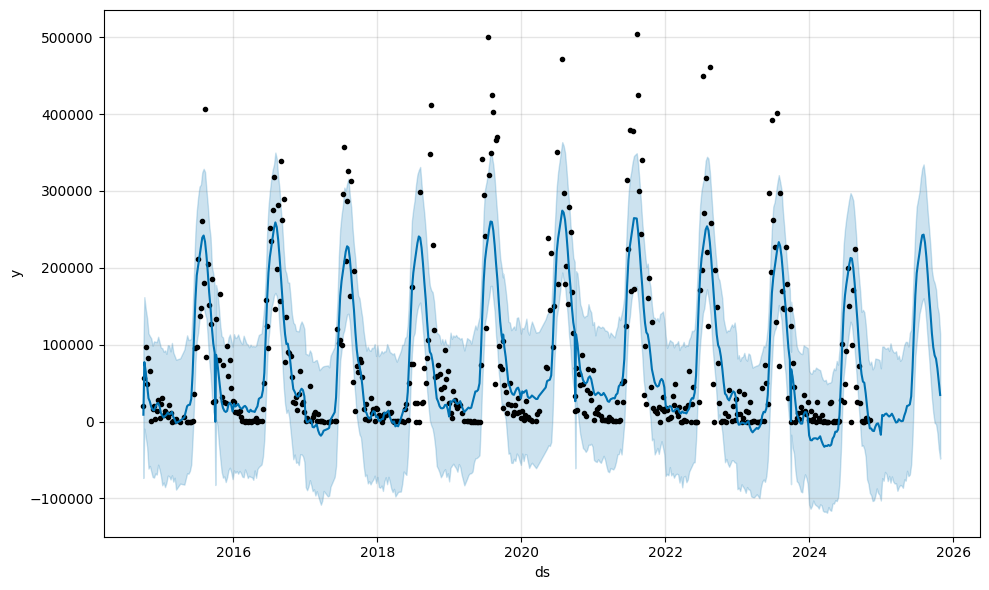

In [102]:
model.plot(forecast);

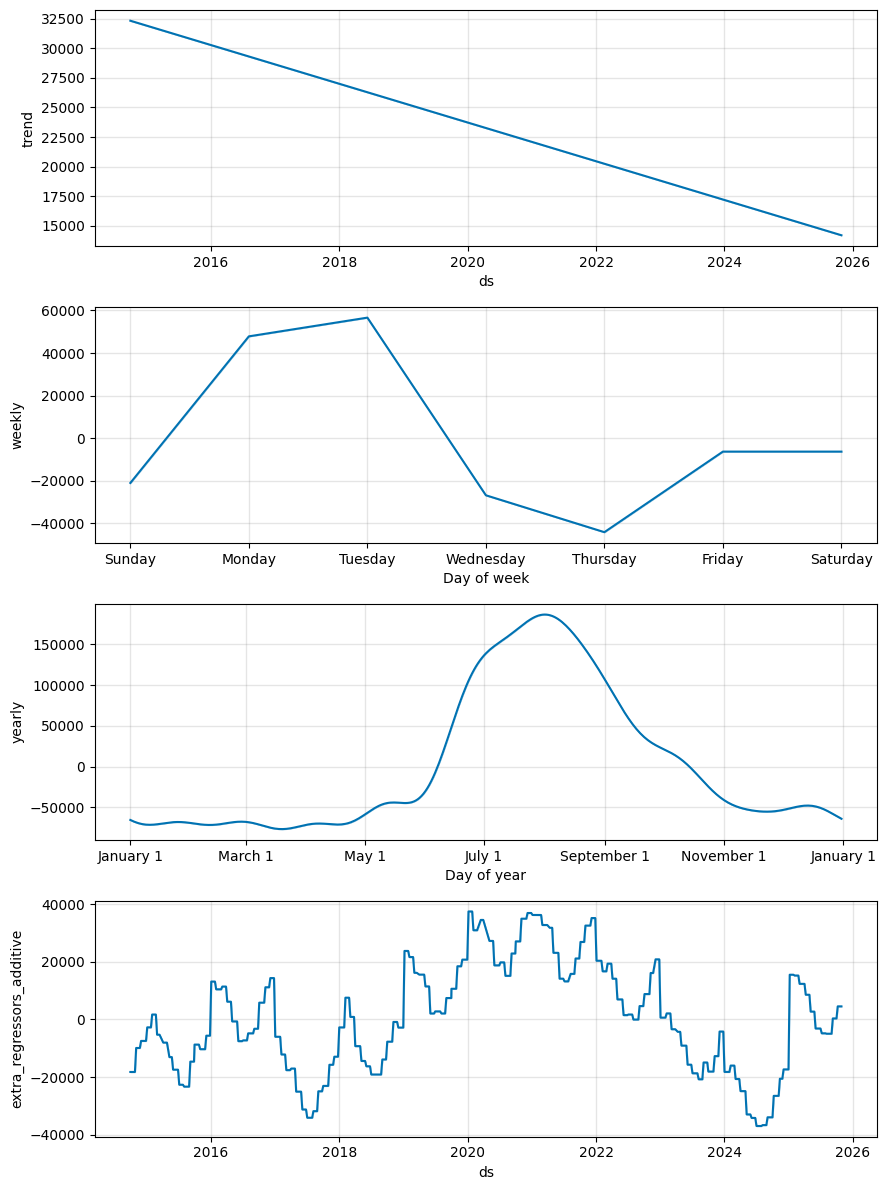

In [103]:
model.plot_components(forecast);

## LightGBM (Gradient Boosting)

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm.callback import early_stopping
from lightgbm import log_evaluation
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.model_selection import RandomizedSearchCV

Creamos los conjuntos de entrenamient, validación y test y entrenamos el modelo. Usamos randomizedsearchCV para buscar los mejores hiperparámetros dentro de un grupo dado. 

In [ ]:
corte1 = '2023-10-01'
df_train = df[df['Date'] < '2023-07-01'].copy()
df_val = df[df['Date'].between('2023-07-01', corte1, inclusive='left')].copy()
df_test = df[df['Date'] >= corte1].copy()

#df_train['Semana'] = df_train['Date'].dt.isocalendar().week
#df_val['Semana'] = df_val['Date'].dt.isocalendar().week
#df_test['Semana'] = df_test['Date'].dt.isocalendar().week

df_train['Mes'] = df_train['Date'].dt.month
df_val['Mes'] = df_val['Date'].dt.month
df_test['Mes'] = df_test['Date'].dt.month

X_train = df_train.drop(['kg', 'Date', 'Product', 'Euro Value', 'Año', 'Unit Value'], axis=1)
y_train = df_train['kg']

X_val = df_val.drop(['kg', 'Date', 'Product', 'Euro Value', 'Año', 'Unit Value'], axis=1)
y_val = df_val['kg']

X_test = df_test.drop(['kg', 'Date', 'Product', 'Euro Value', 'Año', 'Unit Value'], axis=1)
y_test = df_test['kg']


model = lgb.LGBMRegressor(objective='regression', boosting_type='gbdt', metric='mae', random_state=42)

param_dist = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'num_leaves': [20, 31, 62, 100], 'max_depth': [-1, 5, 10], 
              'min_data_in_leaf': [10, 20, 30], 'feature_fraction': [0.6, 0.8, 1.0]}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

model = random_search.best_estimator_
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mae', callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=20)])

# Evaluamos el modelo
y_pred = model.predict(X_test)

r2score, mae, rmse = r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False)
print(f'R^2 = {r2score}, MAE: {mae}, RMSE: {rmse}')

Vemos que variables influyen más en el modelo

In [ ]:
# Variables que más influyen en el modelo
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores Reales', alpha=0.7)
plt.plot(y_pred, label='Predicciones', alpha=0.7)
plt.legend()
plt.title('Comparación de Valores Reales vs Predicciones')
plt.show()

### Con escalado logarítmico

In [ ]:
corte1 = '2023-10-01'
df_train = df[df['Date'] < '2023-07-01'].copy()
df_val = df[df['Date'].between('2023-07-01', corte1, inclusive='left')].copy()
df_test = df[df['Date'] >= corte1].copy()

df_train['Semana'] = df_train['Date'].dt.isocalendar().week
df_val['Semana'] = df_val['Date'].dt.isocalendar().week
df_test['Semana'] = df_test['Date'].dt.isocalendar().week

X_train = df_train.drop(['kg', 'Date', 'Product', 'Euro Value', 'Unit Value'], axis=1)
y_train = df_train['kg']

X_val = df_val.drop(['kg', 'Date', 'Product', 'Euro Value', 'Unit Value'], axis=1)
y_val = df_val['kg']

X_test = df_test.drop(['kg', 'Date', 'Product', 'Euro Value', 'Unit Value'], axis=1)
y_test = df_test['kg']

y_train_log = np.log1p(y_train) 
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

model = lgb.LGBMRegressor(objective='regression', boosting_type='gbdt', metric='mae', random_state=42)
param_dist = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'num_leaves': [20, 31, 62, 100], 'max_depth': [-1, 5, 10], 
              'min_data_in_leaf': [10, 20, 30], 'feature_fraction': [0.6, 0.8, 1.0]}
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train_log)

model = random_search.best_estimator_
model.fit(X_train, y_train_log, eval_set=[(X_val, y_val_log)], eval_metric='mae', callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=20)])

# Evaluamos el modelo
y_pred_log = model.predict(X_test)

r2score, mae, rmse = r2_score(y_test, np.expm1(y_pred_log)), mean_absolute_error(y_test, np.expm1(y_pred_log)), mean_squared_error(y_test, np.expm1(y_pred_log), squared=False)
print(f'R^2 = {r2score}, MAE: {mae}, RMSE: {rmse}')

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Valores Reales', alpha=0.7)
plt.plot(np.expm1(y_pred_log), label='Predicciones', alpha=0.7)
plt.legend()
plt.title('Comparación de Valores Reales vs Predicciones')
plt.show()

## SARIMAX

En este apartado probamos un modelo SARIMAX, especialista en series temporales. 

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error

In [9]:
df_sarima = df.copy()
df_sarima['Date'] = pd.to_datetime(df_sarima['Date'])
df_sarima.set_index('Date', inplace=True)

y = df_sarima['kg']
exog_vars = ['Temperatura', 'Precipitación', 'Masc. Adultos medios (35-54 años)']
exog = df_sarima[exog_vars]

train_y = y[:'2023-07-01']
test_y = y['2023-07-01':] 
train_exog = exog[:'2023-07-01']
test_exog = exog['2023-07-01':]

model = SARIMAX(train_y, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))  
sarima = model.fit(disp=False)

forecast = sarima.forecast(steps=len(test_y), exog=test_exog)

rmse = root_mean_squared_error(test_y, forecast)
print(f"RMSE: {rmse}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE: 283597.308619124


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


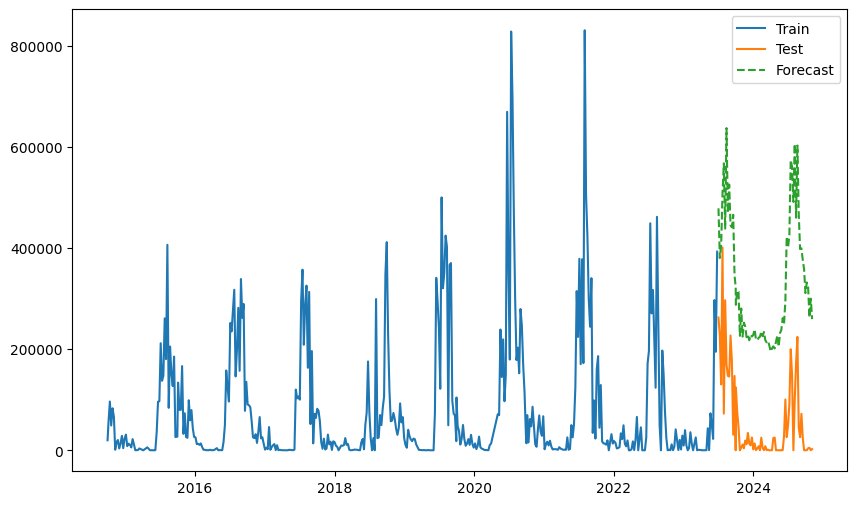

In [10]:
# Graficar resultados
fig = plt.figure(figsize=(10, 6))
plt.plot(train_y, label='Train')
plt.plot(test_y, label='Test')
plt.plot(test_y.index, forecast, label='Forecast', linestyle='--')
plt.legend()
plt.show()

## Regresión lineal

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:
df_regression = df.copy()
df_regression = df_regression.groupby(['Año','Mes']).agg({
    'kg': 'sum', 
    **{col: 'first' for col in df.columns if col not in ['kg', 'Partner', 'Date', 'Member State']}
})

display(df_regression)

X = df_regression.drop(['kg', 'Product', 'Euro Value', 'Unit Value'], axis=1)
y = df_regression['kg']

In [ ]:
X_train = X.loc[X.index.get_level_values('Año') < 2023]
X_test = X.loc[X.index.get_level_values('Año') >= 2023]

y_train = y.loc[y.index.get_level_values('Año') < 2023]
y_test = y.loc[y.index.get_level_values('Año') >= 2023]

# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [ ]:
r2score, mae, rmse = r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred), root_mean_squared_error(y_test, y_pred)

print(f'R^2 = {r2score}, MAE: {mae}, RMSE: {rmse}')
for i, col in enumerate(X.columns):
    print(f'{col}: {model.coef_[i]}')

fig_1 = plt.figure(figsize=(20, 16))
plt.barh(X.columns[::-1], model.coef_[::-1])
plt.title('Coeficientes del Modelo de Regresión Lineal')

fig_2 = plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='kg reales', alpha=0.7)
plt.plot(y_pred, label='Predicciones de importación', alpha=0.7)
plt.legend()
plt.title('Comparación de kg reales vs predicciones')
plt.show()



## Red neuronal recurrente

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

In [ ]:
df_neuronal = df.copy()
df_neuronal['Date'] = pd.to_datetime(df_neuronal['Date'])
df_neuronal['Mes'] = df_neuronal['Date'].dt.month

X_raw = df_neuronal.drop(['kg', 'Date', 'Product', 'Euro Value', 'Unit Value'], axis=1)
y_raw = df_neuronal['kg']

scaler = StandardScaler()
X_raw = scaler.fit_transform(X_raw)

lookback = 12

X, y = [], []
for i in range(len(X_raw) - lookback):
    X.append(X_raw[i:i+lookback]) 
    y.append(y_raw[i+lookback])

X = np.array(X) 
y = np.array(y) 

print("Forma de X:", X.shape)  
print("Forma de y:", y.shape) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(50, activation= 'relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(model.summary())

In [ ]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Graficar la pérdida 
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.legend()
plt.title('Pérdida del modelo')
plt.show()

In [ ]:
# Evaluar el modelo en los datos de prueba
loss, mae = model.evaluate(X_test, y_test)
print(f"Pérdida (MSE): {loss}, Error Absoluto Medio (MAE): {mae}")


In [ ]:
prediccion = model.predict(X_test)

y_test_flat = y_test.flatten()  # Asegúrate de que es 1D
y_pred_flat = prediccion.flatten() 

plt.figure(figsize=(10, 6))
plt.plot(y_test_flat, label='Valores Reales')
plt.plot(y_pred_flat, label='Predicciones')
plt.legend()
plt.title('Comparación entre valores reales y predicciones')
plt.show()